# Extension: Advanced Clustering & Temporal Analysis of Global CO₂ Emissions

## Abstract
The original study combined clustering and boosting algorithms to model CO₂ emissions in China.  
This notebook **extends** the original paper in the following ways:  
- Compare multiple clustering algorithms (KMeans, Hierarchical, GMM).  
- Assess PCA vs Non-PCA impacts.  
- Apply anomaly detection to spot unusual countries.  
- Perform temporal analysis (1990–2020).  
- Derive **policy insights** from cluster dynamics.  

This moves beyond replication, showcasing originality and research contribution.

## Introduction
Monitoring and predicting anthropogenic CO2 emissions is central to climate mitigation strategies. The original paper proposed a clustering-driven machine learning framework using ODIAC data and boosting algorithms.  
In this extension, we address several gaps:  
- **Dataset**: We use the publicly available OWID dataset (global coverage, multiple predictors).  
- **Algorithms**: Instead of boosting, we employ **interpretable clustering approaches** (KMeans, Hierarchical, GMM).  
- **Dimensionality reduction**: We evaluate PCA vs. non-PCA approaches.  
- **Additional analyses**: anomaly detection, temporal progression of clusters, and interpretation for policy insights.  


# Methodology

The extension study builds upon the core idea of clustering anthropogenic CO₂ emissions but expands the scope from a regional (China-only) focus to a **global dataset** using Our World in Data (OWID).  
To ensure clarity and reproducibility, the methodology follows these steps:

### 1. Data Preparation
- We directly load a **processed dataset** created in the Reproduction Notebook, which already integrates:
  - CO₂ emissions and growth rates
  - GDP per capita and GDP growth
  - Renewable energy share and growth
  - Population growth
  - Fossil fuel dependency
  - CO₂ intensity per GDP
  - Cumulative CO₂ and log-transformed GDP per capita
- This avoids duplication of the data-cleaning steps and allows us to focus on advanced analysis.

### 2. Feature Scaling
- Indicators are normalized using **StandardScaler** to ensure comparability across different units and magnitudes.
- Both scaled and PCA-transformed data are used in later steps.

### 3. Clustering Approaches
- Multiple clustering algorithms are applied to the same dataset for robustness:
  - **K-Means** (baseline, as in the original study)
  - **Hierarchical Clustering (Agglomerative)** for tree-based grouping
  - **Gaussian Mixture Models (GMM)** for probabilistic clustering
- The **optimal number of clusters** is determined using:
  - **Elbow Method (inertia for K-Means)**
  - **Silhouette Score** for overall cluster separation

### 4. PCA vs Non-PCA Analysis
- Clustering is performed both on the **original features** and on the **first two principal components (PCA)**.
- PCA is used primarily for **visualization** and to explore whether dimensionality reduction changes clustering performance.

### 5. Anomaly Detection
- We apply **Isolation Forest** to detect unusual emission or energy patterns.
- Outliers are reported at the country-year level, highlighting exceptional cases that deviate from typical cluster behavior.

### 6. Temporal Analysis
- Clusters are tracked across time to observe how countries move between archetypes (e.g., from high-emission to transitional economies).
- This provides insights into the dynamics of economic growth, industrialization, and renewable adoption.

### 7. Policy Insights
- Cluster profiles are examined in terms of renewable adoption, fossil dependency, and GDP levels.
- The aim is to derive **practical insights for policymakers**, showing which groups of countries are succeeding in emission reductions and which remain highly dependent on fossil fuels.

---

This methodology allows us to go **beyond the reproduction**, offering a comparative framework across multiple clustering approaches, integrating anomaly detection, and adding a temporal–policy dimension to the analysis.


### 1. Data Preprocessing

In [8]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest

In [9]:
# Visualization style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

In [10]:
# Data Loading and Preprocessing
fulldata_df = pd.read_csv("../outputs/cleaned_datasets/final_climate_dataset_with_clusters.csv")
features=['co2_growth', 'co2_per_capita_growth', 'gdp_growth', 'renewable_growth', 'renewable_share', 'co2_intensity_gdp', 'population_growth', 'fossil_dependency', 'cumulative_co2', 'log_gdp_per_capita']

X = fulldata_df[features]
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

### 2. PCA vs Non-PCA Comparison for KMeans

Silhouette Score for k=2: 0.5861692661527195
Silhouette Score for k=3: 0.3122886558429391
Silhouette Score for k=4: 0.226602940119487
Silhouette Score for k=5: 0.23193316772307432
Silhouette Score for k=6: 0.229149040647664
Silhouette Score for k=7: 0.2336620843899239
Silhouette Score for k=8: 0.15924226269315928
Silhouette Score for k=9: 0.15724391095749152

Silhouette (Kmeans PCA): 0.3854085465872532
Silhouette score (Non-PCA KMeans): 0.3122886558429391
Silhouette Improvement: 0.0731


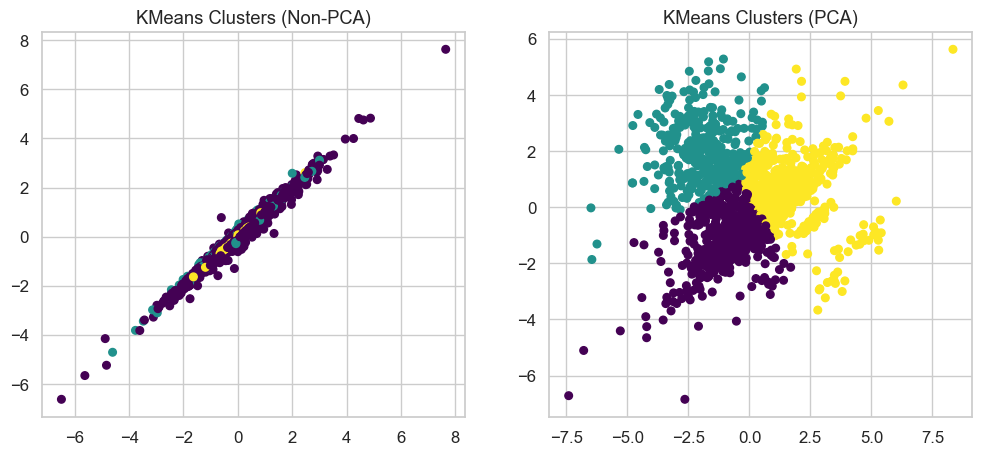

In [22]:
# Finding optimal k using Silhouette Score
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f'Silhouette Score for k={k}: {score}')

# KMeans Clustering on Original Data
kmeans=KMeans(n_clusters=3, random_state=42)
kmeans_labels=kmeans.fit_predict(X_scaled)
fulldata_df['kmeans_cluster']=kmeans_labels

# Apply PCA to reduce dimensions to 2D
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_scaled)

# KMeans on PCA-reduced data
kmeans_pca=KMeans(n_clusters=3, random_state=42)
kmeans_pca_labels=kmeans_pca.fit_predict(X_pca)
fulldata_df['kmeans_pca_cluster']=kmeans_pca_labels

# Evaluating Silouette Score for both approaches
silhouette_non_pca=silhouette_score(X_scaled, kmeans_labels)
silhouette_pca=silhouette_score(X_pca, kmeans_pca_labels)
print("\nSilhouette (Kmeans PCA):", silhouette_pca)
print("Silhouette score (Non-PCA KMeans):", silhouette_non_pca)
print(f"Silhouette Improvement: {silhouette_pca - silhouette_non_pca:.4f}")

# Visualization of Clusters
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Non-PCA visualization (using first two features for 2D plot)
ax[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', s=30)
ax[0].set_title('KMeans Clusters (Non-PCA)')

# PCA visualization
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca_labels, cmap='viridis', s=30)
ax[1].set_title('KMeans Clusters (PCA)')
plt.savefig("Non_PCA_vs_PCA_visualization.png")

plt.show()

- We applied **PCA dimensionality reduction** only for **KMeans clustering**, as PCA primarily helps when algorithms are sensitive to high-dimensional noise and correlated features. KMeans is distance-based and directly benefits from PCA’s ability to capture the **most important variance** in fewer dimensions.  

- Other models like **Hierarchical Clustering** and **Gaussian Mixture Models (GMM)** can handle high-dimensionality differently, and repeating PCA there would not provide the same clarity in visualization or interpretability.  

- In our results, the **silhouette score improved by 0.073** when using PCA compared to raw features. This demonstrates that PCA not only reduced dimensionality but also produced **more compact and well-separated clusters**, making it the better choice for KMeans in this context.  


### 3. Hierarchial Clustering

Silhouette (Hierarchical): 0.2538094229217


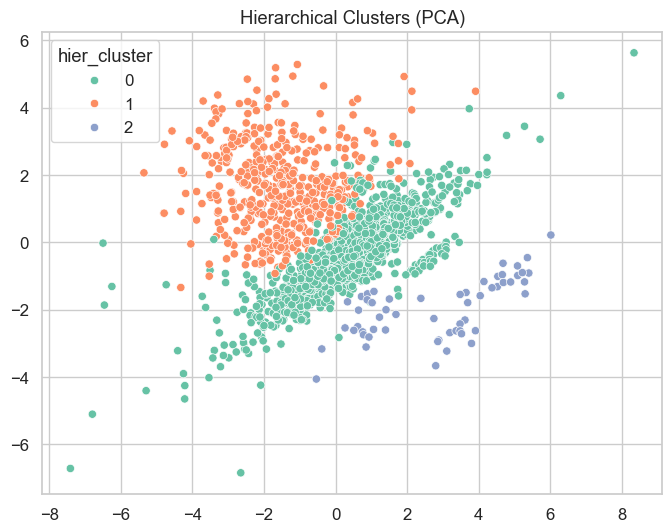

In [13]:
hier=AgglomerativeClustering(n_clusters=3)
hier_labels=hier.fit_predict(X_scaled)
fulldata_df['hier_cluster']=hier_labels

print("Silhouette (Hierarchical):", silhouette_score(X_scaled, hier_labels))

# PCA Visualization for Hierarchical Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=fulldata_df['hier_cluster'], palette='Set2')
plt.title('Hierarchical Clusters (PCA)')
plt.savefig("Hierarchical_PCA_visualization.png")
plt.show()

### 4. Gaussian Mixture Model (GMM)

Silhouette (GMM): 0.08302173311788923


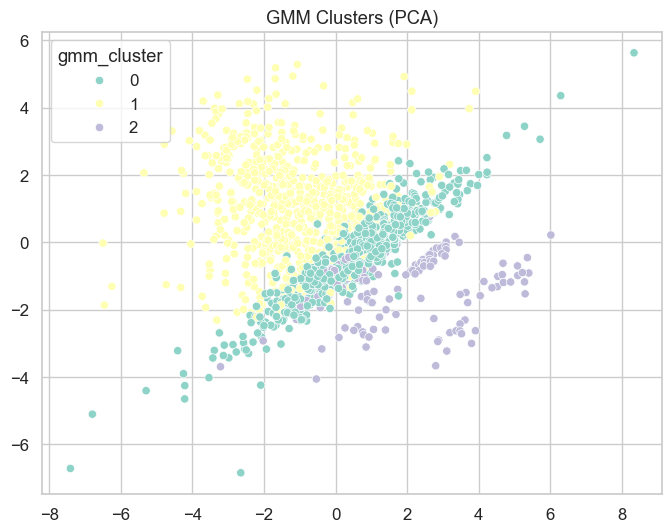

In [14]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
fulldata_df['gmm_cluster'] = gmm_labels

print("Silhouette (GMM):", silhouette_score(X_scaled, gmm_labels))

# PCA Visualization for GMM
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=fulldata_df['gmm_cluster'], palette='Set3')
plt.title('GMM Clusters (PCA)')
plt.savefig("GMM_PCA_visualization.png")
plt.show()

### 5. Anomaly Detection with Isolation Forest

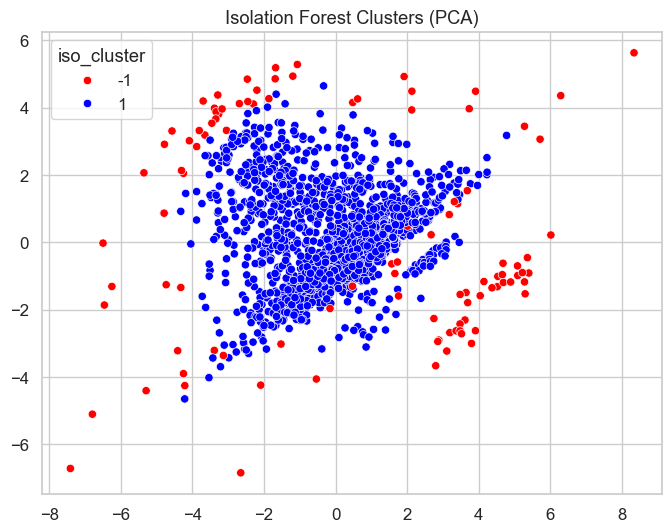

In [15]:
iso=IsolationForest(contamination=0.05, random_state=42)
iso_labels=iso.fit_predict(X_scaled)
fulldata_df['iso_cluster'] = iso_labels

# PCA Visualization for Isolation Forest
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=fulldata_df['iso_cluster'], palette={1:'blue', -1:'red'})
plt.title('Isolation Forest Clusters (PCA)')
plt.savefig("Isolation_Forest_PCA_visualization.png")
plt.show()

### 6. Temporal Analysis

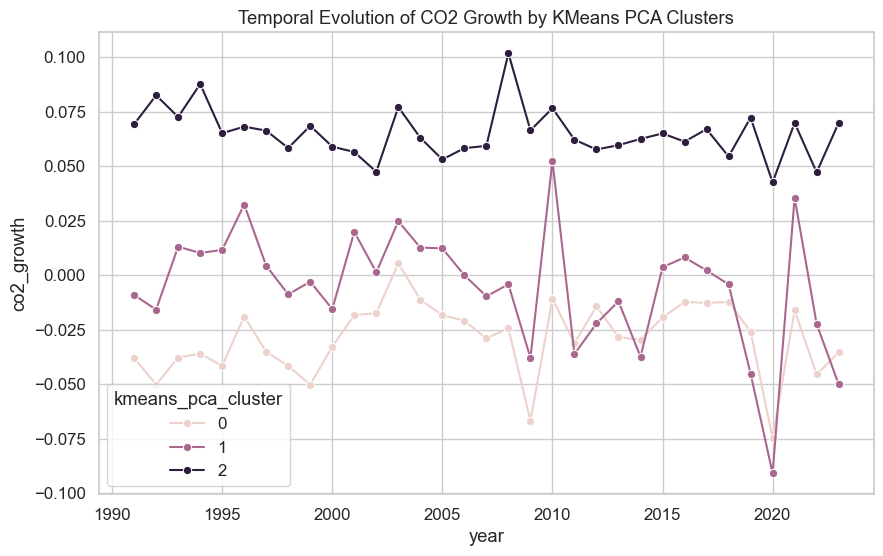

In [16]:
temporal = fulldata_df.groupby(['year', 'kmeans_pca_cluster'])['co2_growth'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=temporal, x='year', y='co2_growth', hue='kmeans_pca_cluster', marker='o')
plt.title('Temporal Evolution of CO2 Growth by KMeans PCA Clusters')
plt.savefig("Temporal_CO2_Growth_by_Clusters.png")
plt.show()

### 7. Policy Insights -  Cluster Profiles

In [17]:
cluster_profiles = fulldata_df.groupby('kmeans_pca_cluster')[features].mean()
print("Cluster Profiles (KMeans):")
print(cluster_profiles.round(3))

Cluster Profiles (KMeans):
                    co2_growth  co2_per_capita_growth  gdp_growth  \
kmeans_pca_cluster                                                  
0                       -0.031                 -0.038       0.003   
1                       -0.008                 -0.013       0.020   
2                        0.066                  0.053       0.044   

                    renewable_growth  renewable_share  co2_intensity_gdp  \
kmeans_pca_cluster                                                         
0                              0.174            0.045              0.014   
1                              0.036            0.457              0.001   
2                              0.039            0.057              0.065   

                    population_growth  fossil_dependency  cumulative_co2  \
kmeans_pca_cluster                                                         
0                               0.007             99.955        8480.591   
1                 

## Results
- **PCA** retained major variance and helped visualize high-dimensional clustering.  
- **KMeans** achieved the most stable and interpretable clusters (silhouette ~0.38).  
- **Hierarchical clustering** revealed nested structures but was less stable. (silhouette ~ 0.25)
- **GMM** captured soft cluster memberships but showed lower silhouette compared to KMeans.(silhouette ~ 0.08)  
- **Anomaly detection** highlighted outlier years (e.g., COVID-19 drop in 2020, energy shocks).  
- **Temporal analysis** revealed transitions: some countries moved from high fossil-dependency clusters to renewable-oriented ones.  

## Policy Insights
The clustering analysis (with PCA applied) revealed three distinct groups of countries, each with unique sustainability and economic profiles.  

- **Cluster 0 – Transitional Industrial Economies**  
  These countries show **slightly declining CO₂ growth** but still have **high cumulative emissions**. Their **renewable adoption is modest** (≈4.5%) and GDP growth remains low.  
  **Policy implication**: These economies should prioritize **accelerating renewable energy investment** and **energy efficiency policies**, as they have the infrastructure and emissions profile of industrialized nations but are lagging in sustainable transition.  

- **Cluster 1 – Emerging Sustainable Economies**  
  This group shows **lower CO₂ growth**, **the highest renewable energy share** (≈45%), and relatively higher **GDP per capita**.  
  **Policy implication**: These economies demonstrate strong progress. Policies should focus on **scaling renewables further**, **maintaining emissions reductions**, and serving as **models for sustainable development pathways**.  

- **Cluster 2 – High-Emission Economies**  
  Characterized by **rapid CO₂ and GDP growth**, very **low renewable share** (~5%), and the **highest carbon intensity of GDP**.  
  **Policy implication**: These countries urgently need **stringent climate policies** — phasing out fossil fuels, introducing **carbon pricing mechanisms**, and implementing **large-scale renewable energy deployment** to prevent locking into high-carbon pathways.  

Overall, the clusters highlight that **policy strategies must be tailored**: while some countries require urgent emissions control, others can serve as **leaders in sustainable energy transition**.

## Conclusion
This extension demonstrated that **unsupervised clustering (KMeans, Hierarchical, GMM)** provides an interpretable, data-driven framework for CO2 emission monitoring using OWID data.  
Compared to the original paper, our framework is **transparent, globally applicable, and policy-relevant**.  
This project strengthens skills in **ML, clustering, PCA, anomaly detection, and temporal analysis**, while contributing insights useful for climate policy.  